In [1]:
%load_ext watermark


In [2]:
import os

from IPython.display import display
import itertools as it
import matplotlib.ticker as mpl_ticker
import outset as otst
import pandas as pd
import polars as pl
import seaborn as sns
from teeplot import teeplot as tp


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-01-26T16:37:34.834178+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.5.0-1025-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

seaborn   : 0.13.2
outset    : 0.1.9
matplotlib: 3.9.2
pandas    : 2.2.3
teeplot   : 1.2.0
polars    : 1.9.0

Watermark: 2.4.3



In [4]:
teeplot_subdir = os.environ.get("NOTEBOOK_NAME", "2025-01-18-cpp-bench-speed")
teeplot_subdir


'2025-01-18-cpp-bench-speed'

## Prep Data


In [5]:
df = pl.concat(
    [
        pl.read_csv("https://osf.io/m6wne/download"),
        pl.read_csv("https://osf.io/sb4zw/download"),
    ],
)
df = (
    df.cast(
        {
            "memory_bytes": pl.Int32,
            "num_items": pl.Int32,
            "num_sites": pl.Int32,
            "duration_s": pl.Float64,
            "replicate": pl.Int32,
        },
    )
    .with_columns(
        duration_per_item_ns=(
            pl.col("duration_s") * 1_000_000_000 / pl.col("num_items")
        )
    )
    .filter(pl.col("algo_name") != "naive_steady_algo")
    .with_columns(
        algo_name=pl.col("algo_name").replace(
            {"zhao_steady_algo": "naive_steady_algo"},
        ),
    )
    .with_columns(
        algorithm=pl.col("algo_name").map_elements(
            {
                "control_ring_algo": "\u200bcontrol: ringbuf",
                "control_throwaway_algo": "\u200bcontrol: discard",
                "dstream.steady_algo": "dstream steady",
                "dstream.stretched_algo": "dstream stretched",
                "dstream.tilted_algo": "dstream tilted",
                "naive_steady_algo": "naive steady",
                "zhao_tilted_algo": "naive tilted",
                # "zhao_steady_algo": "zhao steady",
            }.__getitem__,
            return_dtype=str,
        )
    )
)

display(df.describe()), display(df.head()), display(df.tail());


statistic,algo_name,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,duration_per_item_ns,algorithm
str,str,str,f64,f64,f64,f64,f64,f64,str
"""count""","""3360""","""3360""",3360.0,3360.0,3360.0,3360.0,3360.0,3360.0,"""3360"""
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,"""0"""
"""mean""",null,null,951.190476,370000.0,1360.0,9.5,0.005601,62.384845,null
"""std""",null,null,3180.661267,447056.463983,1620.196674,5.76714,0.020233,392.890197,null
"""min""","""control_ring_algo""","""clang++""",12.0,10000.0,64.0,0.0,0.000019,1.8498,"""dstream steady"""
"""25%""",null,null,36.0,10000.0,256.0,5.0,0.00013,1.942506,null
"""50%""",null,null,132.0,100000.0,1024.0,10.0,0.000619,4.493915,null
"""75%""",null,null,516.0,1e6,1024.0,14.0,0.003125,12.5763,null
"""max""","""zhao_tilted_algo""","""g++""",16960.0,1e6,4096.0,19.0,0.209822,4680.4235,"""​control: ringbuf"""


algo_name,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,duration_per_item_ns,algorithm
str,str,i32,i32,i32,i32,f64,f64,str
"""control_ring_algo""","""clang++""",12,10000,64,0,0.000019,1.8756,"""​control: ringbuf"""
"""control_ring_algo""","""clang++""",12,10000,64,1,0.000019,1.8755,"""​control: ringbuf"""
"""control_ring_algo""","""clang++""",12,10000,64,2,0.000019,1.8756,"""​control: ringbuf"""
"""control_ring_algo""","""clang++""",12,10000,64,3,0.000019,1.8665,"""​control: ringbuf"""
"""control_ring_algo""","""clang++""",12,10000,64,4,0.000019,1.8655,"""​control: ringbuf"""


algo_name,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,duration_per_item_ns,algorithm
str,str,i32,i32,i32,i32,f64,f64,str
"""zhao_tilted_algo""","""g++""",143,1000000,4096,15,0.013005,13.004743,"""naive tilted"""
"""zhao_tilted_algo""","""g++""",143,1000000,4096,16,0.013032,13.032135,"""naive tilted"""
"""zhao_tilted_algo""","""g++""",143,1000000,4096,17,0.013003,13.003431,"""naive tilted"""
"""zhao_tilted_algo""","""g++""",143,1000000,4096,18,0.013017,13.017118,"""naive tilted"""
"""zhao_tilted_algo""","""g++""",143,1000000,4096,19,0.013011,13.011486,"""naive tilted"""


## Plot


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:225: UserWarning: 
The markers list has fewer values (2) than needed (7) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-01-18-cpp-bench-speed/col=compiler+hue=algo-name+kind=line+palette=muted+style=algo-name+viz=relplot+x=num-sites+y=duration-s+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/col=compiler+hue=algo-name+kind=line+palette=muted+style=algo-name+viz=relplot+x=num-sites+y=duration-s+ext=.png


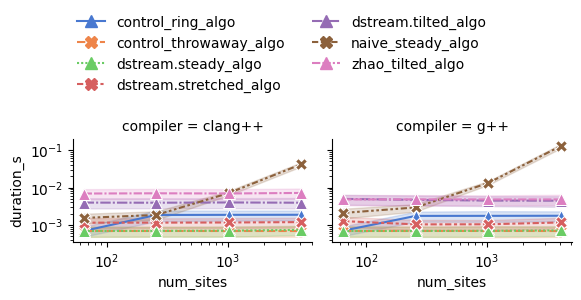

In [6]:
with tp.teed(
    sns.relplot,
    data=df,
    x="num_sites",
    y="duration_s",
    col="compiler",
    hue="algo_name",
    style="algo_name",
    palette="muted",
    kind="line",
    aspect=1.5,
    markers=["^", "X"],
    ms=8,
    height=2,
    teeplot_subdir=teeplot_subdir,
) as g:
    g.set(xscale="log", yscale="log")
    sns.move_legend(
        g,
        "lower center",
        bbox_to_anchor=(0.35, 1),
        ncol=2,
        title=None,
        frameon=False,
    )
    g.tight_layout()


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:225: UserWarning: 
The markers list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-01-18-cpp-bench-speed/col=algorithm+hue=buffer-capacity+kind=line+palette=muted+row=compiler+style=buffer-capacity+viz=relplot+x=num-items+y=duration-s+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/col=algorithm+hue=buffer-capacity+kind=line+palette=muted+row=compiler+style=buffer-capacity+viz=relplot+x=num-items+y=duration-s+ext=.png


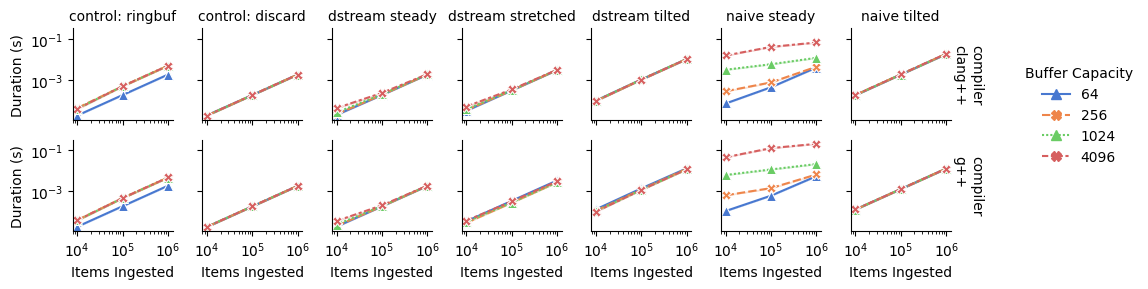

In [7]:
with tp.teed(
    sns.relplot,
    data=df.with_columns(
        pl.col("num_sites").alias("Buffer Capacity"),
    ),
    x="num_items",
    y="duration_s",
    col="algorithm",
    row="compiler",
    hue="Buffer Capacity",
    style="Buffer Capacity",
    facet_kws=dict(margin_titles=True),
    palette="muted",
    kind="line",
    aspect=1,
    markers=["^", "X"],
    ms=7,
    height=1.5,
    teeplot_subdir=teeplot_subdir,
) as g:
    g.set(xscale="log", yscale="log")
    g.set_titles(
        col_template="{col_name}",
        row_template="{row_var}\n{row_name}",
    )
    g.set_xlabels("Items Ingested")
    g.set_ylabels("Duration (s)")
    sns.move_legend(
        g,
        "upper left",
        bbox_to_anchor=(0.87, 0.8),
        ncol=1,
        title="Buffer Capacity",
        frameon=False,
    )
    g.tight_layout()


num_items=10000, exclude=


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4783/3161709880.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


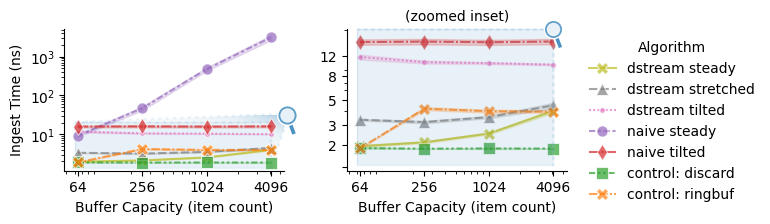

num_items=10000, exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4783/3161709880.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


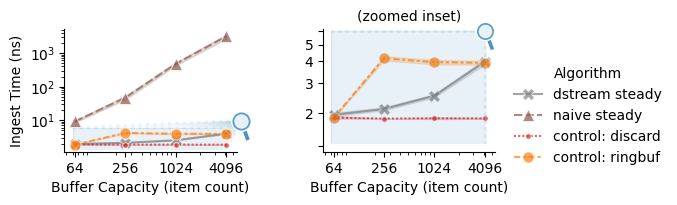

num_items=1000000, exclude=


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4783/3161709880.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


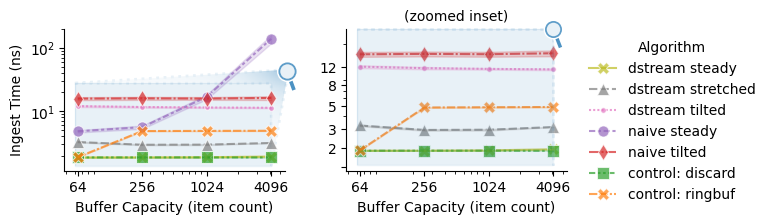

num_items=1000000, exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4783/3161709880.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


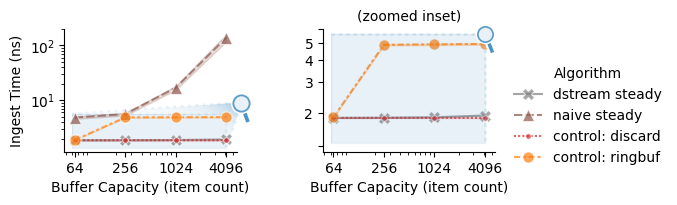

num_items=10000, exclude=


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4783/3161709880.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


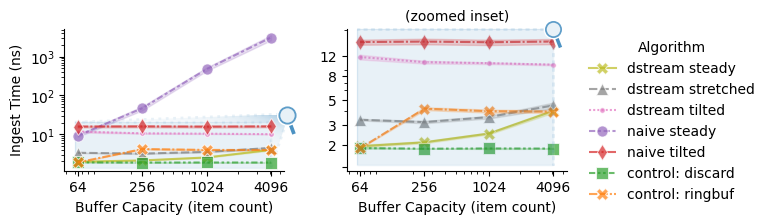

num_items=10000, exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4783/3161709880.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=10000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


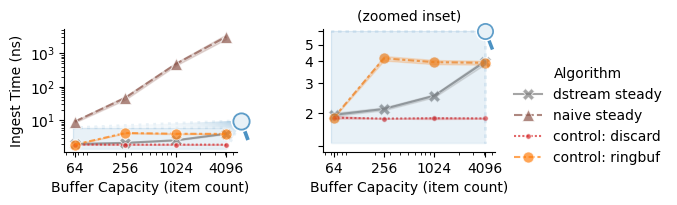

num_items=1000000, exclude=


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: 
The markers list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4783/3161709880.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


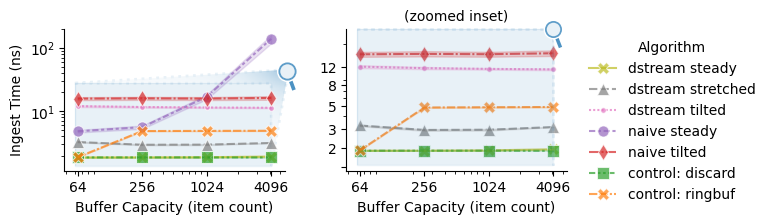

num_items=1000000, exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/outset/_OutsetGrid.py:835: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  plotter(self.__data, *args, ax=self.source_axes, **kwargs)
/tmp/ipykernel_4783/3161709880.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+num_items=1000000+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


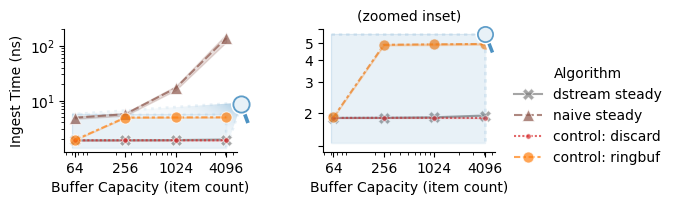

In [8]:
for compiler, num_items, exclude in it.product(
    df["compiler"].unique(),
    [10_000, 1_000_000],
    ["", "dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo"],
):
    print(f"num_items={num_items}, exclude={exclude}")
    data = (
        df.with_columns(
            is_naive=pl.col("algo_name") == "naive_steady_algo",
        )
        .filter(pl.col("num_items") == num_items)
        .filter(~pl.col("algo_name").is_in(exclude.split(",")))
        .sort(
            "algorithm",
        )
        .to_pandas()
        .astype(
            {"algorithm": "category"},
        )
    )
    with tp.teed(
        otst.OutsetGrid,
        data=data,
        x="num_sites",
        y="duration_per_item_ns",
        row="is_naive",
        row_order=[False],
        marqueeplot_kws=dict(
            frame_outer_pad=(4.0, 0.2),
            frame_inner_pad=(4.0, 0.5),
            leader_stretch=0.8,
            frame_edge_kws={"alpha": 0.1},
            leader_edge_kws={"alpha": 0.1},
        ),
        height=2.2 if exclude else 2.5,
        aspect=1.2,
        palette="tab10_r",
        teeplot_subdir=teeplot_subdir,
        teeplot_outattrs=dict(
            compiler=compiler.replace("+", "x"),
            exclude=exclude,
            num_items=num_items
        ),
    ) as g:
        g.map_dataframe(
            sns.lineplot,
            x="num_sites",
            y="duration_per_item_ns",
            alpha=0.7,
            hue="algorithm",
            style="algorithm",
            style_order=sorted(data["algorithm"].unique()),
            markers=["X", "^", ".", "o", "d", "s"],
            ms=8,
            palette="tab10_r",
            zorder=otst.util.SplitKwarg(None, -1),
        )
        g.set(xlim=(32 * 1.5, 8192 / 1.5), xscale="log", yscale="log")
        g.marqueeplot(equalize_aspect=False)
        g.set(xlim=(32 * 1.5, 8192 / 1.5), xscale="log", yscale="log")
        g.set_xlabels("Buffer Capacity (item count)")
        g.set_ylabels("Ingest Time (ns)")
        yticks = [1.3, 2, 3, 5, 8, 12]
        ytick_labels = [" ", "2", "3", "5", "8", "12"]
        g.tight_layout()
        g.add_legend(title="Algorithm", bbox_to_anchor=(1.02, 0.45))
        ax = g.axes.flat[1]
        ax.set_ylim(1.2, None)
        ax.set_title("(zoomed inset)", size=10)
        labels = [item.get_text() for item in ax.get_xticklabels()]
        empty_string_labels = [""] * len(labels)
        ax.set_xticklabels(empty_string_labels)
        if exclude:
            yticks = [1.3, 2, 3, 4, 5, 6]
            ytick_labels = ["", "2", "3", "4", "5", " "]
        ax.yaxis.set_major_locator(mpl_ticker.FixedLocator(yticks))
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        g.set(
            xticks=[64, 256, 1024, 4096],
            xticklabels=["64", "256", "1024", "4096"],
        )


/tmp/ipykernel_4783/642019261.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=clangxx+exclude=+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=clangxx+exclude=+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


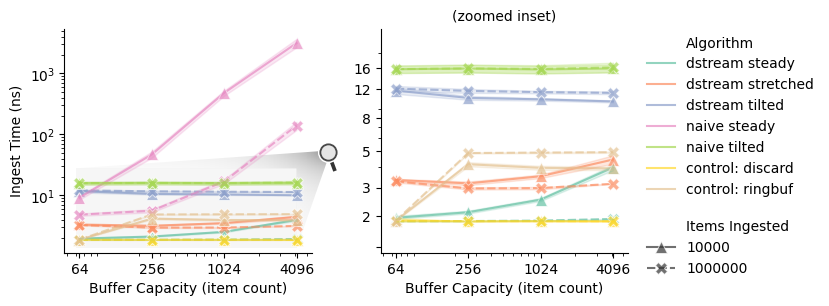

/tmp/ipykernel_4783/642019261.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=clangxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


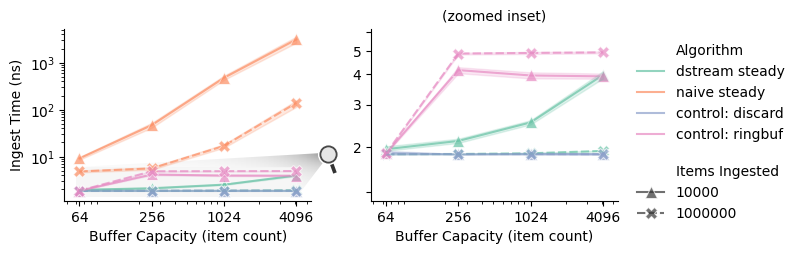

/tmp/ipykernel_4783/642019261.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=gxx+exclude=+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=gxx+exclude=+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


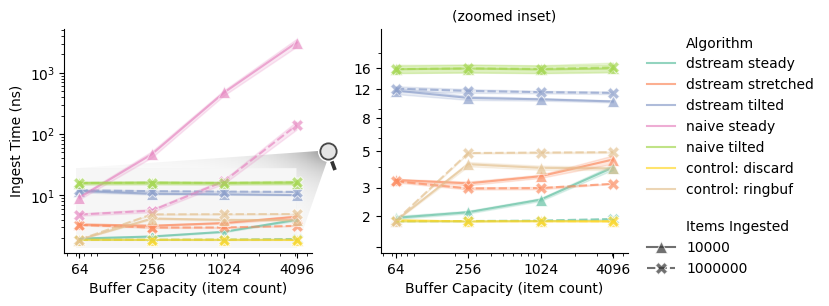

/tmp/ipykernel_4783/642019261.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(empty_string_labels)


teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-01-18-cpp-bench-speed/color=black+compiler=gxx+exclude=dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo+palette=tab10-r+row=is-naive+viz=outsetgrid+x=num-sites+y=duration-per-item-ns+ext=.png


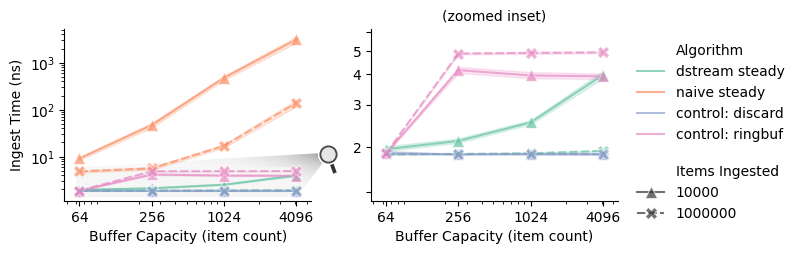

In [9]:
for compiler, exclude in it.product(
    df["compiler"].unique(),
    ("", "dstream.stretched_algo,dstream.tilted_algo,zhao_tilted_algo"),
):
    data = (
        df.with_columns(
            is_naive=pl.col("algo_name") == "naive_steady_algo",
        )
        .with_columns(
            pl.col("num_items").alias("\nItems Ingested"),
            pl.col("algorithm").alias("Algorithm"),
        )
        .filter(pl.col("num_items").is_in([10_000, 1_000_000]))
        .filter(~pl.col("algo_name").is_in(exclude.split(",")))
        .sort(
            "algorithm",
        )
        .to_pandas()
        .astype(
            {"algorithm": "category"},
        )
    )
    with tp.teed(
        otst.OutsetGrid,
        data=data,
        color="black",
        x="num_sites",
        y="duration_per_item_ns",
        row="is_naive",
        row_order=[False],
        marqueeplot_kws=dict(
            # mark_glyph=otst.mark.MarkInlaidAsterisk(),
            frame_outer_pad=(4.0, 0.2),
            frame_inner_pad=(4.0, 0.5),
            leader_stretch=1.8,
        ),
        marqueeplot_source_kws=dict(
            leader_face_kws={"alpha": 0.5, "zorder": -2},
            frame_edge_kws={"alpha": 0.0},
            leader_edge_kws={"alpha": 0.0},
            frame_face_kws={"alpha": 0.07, "facecolor": "gray", "zorder": -2},
            zorder=100,
        ),
        marqueeplot_outset_kws=dict(
            frame_face_kws={"facecolor": "none"},
            frame_edge_kws={"alpha": 0.0},
            leader_edge_kws={"alpha": 0.0},
            mark_glyph=None,
        ),
        height=2.7 if exclude else 3.3,
        aspect=1.2 if exclude else 1,
        palette="tab10_r",
        teeplot_subdir=teeplot_subdir,
        teeplot_outattrs=dict(
            compiler=compiler.replace("+", "x"), exclude=exclude
        ),
    ) as g:
        g.map_dataframe(
            sns.lineplot,
            x="num_sites",
            y="duration_per_item_ns",
            alpha=0.7,
            hue="Algorithm",
            style="\nItems Ingested",
            style_order=sorted(data["num_items"].unique()),
            markers=["^", "X"],
            ms=8,
            palette="Set2",
            zorder=otst.util.SplitKwarg(-1, -1),
        )
        g.set(xlim=(32 * 1.5, 8192 / 1.5), xscale="log", yscale="log")
        g.marqueeplot(
            equalize_aspect=False,
        )
        g.set(xlim=(32 * 1.5, 8192 / 1.5), xscale="log", yscale="log")
        g.set_xlabels("Buffer Capacity (item count)")
        g.set_ylabels("Ingest Time (ns)")
        yticks = [1.3, 2, 3, 5, 8, 12, 16]
        ytick_labels = [" ", "2", "3", "5", "8", "12", "16"]
        g.tight_layout()
        ax = g.axes.flat[1]
        ax.set_ylim(1.2, None)
        ax.set_title("(zoomed inset)", size=10)
        labels = [item.get_text() for item in ax.get_xticklabels()]
        empty_string_labels = [""] * len(labels)
        ax.set_xticklabels(empty_string_labels)
        if exclude:
            yticks = [1.3, 2, 3, 4, 5, 6]
            ytick_labels = ["", "2", "3", "4", "5", " "]
        ax.yaxis.set_major_locator(mpl_ticker.FixedLocator(yticks))
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        g.set(
            xticks=[64, 256, 1024, 4096],
            xticklabels=["64", "256", "1024", "4096"],
        )
        g.tight_layout()
        g.add_legend(bbox_to_anchor=(1.015, 0.47))


,num_sites,algo_name,compiler,speedup_mean,speedup_std,ns_per_op_mean,ns_per_op_std
0,64,control_ring_algo,g++,2.922166,0.011938,1.900922,0.008312
1,64,control_ring_algo,clang++,2.200545,0.010479,1.868507,0.005389
2,256,control_ring_algo,clang++,0.896307,0.003780,5.013178,0.019232
3,256,control_ring_algo,g++,1.421842,0.007076,4.734580,0.011123
4,1024,control_ring_algo,g++,4.547835,0.019360,4.751753,0.015680
5,1024,control_ring_algo,clang++,2.416980,0.006938,5.052634,0.014070
6,4096,control_ring_algo,clang++,13.439347,0.013709,5.078269,0.006163
7,4096,control_ring_algo,g++,43.869316,0.191662,4.779608,0.020618
8,64,control_throwaway_algo,g++,2.971327,0.018102,1.869501,0.010564
9,64,control_throwaway_algo,clang++,2.200626,0.007763,1.868425,0.003256


,num_sites,algo_name,compiler,speedup_mean,speedup_std,ns_per_op_mean,ns_per_op_std
0,64,control_ring_algo,clang++,3.881056,0.263563,1.869150,0.004320
1,64,control_ring_algo,g++,5.848232,0.209851,1.895785,0.002119
2,256,control_ring_algo,g++,16.334656,1.273460,4.000665,0.364095
3,256,control_ring_algo,clang++,6.676438,0.574970,4.325490,0.385264
4,1024,control_ring_algo,clang++,79.849886,8.778339,4.063095,0.455609
5,1024,control_ring_algo,g++,165.239787,10.495345,3.848580,0.276518
6,4096,control_ring_algo,clang++,406.469764,35.528494,3.927880,0.371766
7,4096,control_ring_algo,g++,1192.119577,72.603704,3.916665,0.262718
8,64,control_throwaway_algo,clang++,3.806682,0.155315,1.911875,0.206995
9,64,control_throwaway_algo,g++,5.942767,0.218785,1.865680,0.000356


posx and posy should be finite values
posx and posy should be finite values


teeplots/2025-01-18-cpp-bench-speed/col=compiler+hue=algo-name+kind=bar+viz=catplot+x=num-sites+y=speedup+ext=.pdf


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


teeplots/2025-01-18-cpp-bench-speed/col=compiler+hue=algo-name+kind=bar+viz=catplot+x=num-sites+y=speedup+ext=.png


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


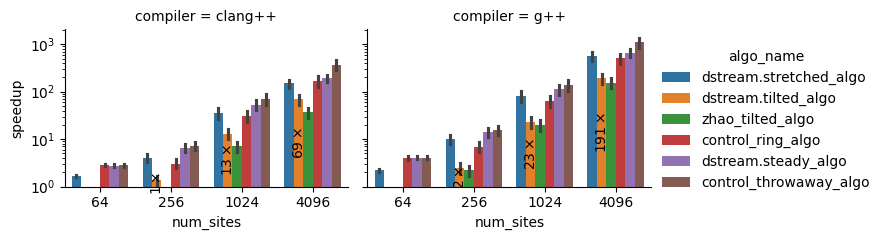

In [10]:
# 1) Compute mean duration per group x algo
df_agg = df.group_by(
    ["compiler", "num_items", "num_sites", "replicate", "algo_name"]
).agg(mean_duration_s=pl.col("duration_s").mean())

# 2) Compute mean duration *just for* "naive_steady_algo"
df_naive = (
    df.filter(pl.col("algo_name") == "naive_steady_algo")
    .group_by(["compiler", "num_items", "num_sites", "replicate"])
    .agg(naive_mean_duration_s=pl.col("duration_s").mean())
)

# 3) Join the two on compiler,num_items,num_sites,replicate
df_speedup = df_agg.join(
    df_naive,
    on=["compiler", "num_items", "num_sites", "replicate"],
    how="left",
).with_columns(
    (pl.lit(1_000_000_000) * pl.col("mean_duration_s") / pl.col("num_items"))
    .alias("ns_per_op"),
    # 4) Speedup = ratio vs. naive_steady_algo
    (pl.col("naive_mean_duration_s") / pl.col("mean_duration_s")).alias(
        "speedup"
    )
)

# Display tabular results
with pd.option_context("display.max_columns", None):
    with pd.option_context("display.max_rows", None):
        display(
            df_speedup.filter(pl.col("num_items") == 1_000_000)
            .group_by(["num_sites", "algo_name", "compiler"])
            .agg(
                speedup_mean=pl.col("speedup").mean(),
                speedup_std=pl.col("speedup").std(),
                ns_per_op_mean=pl.col("ns_per_op").mean(),
                ns_per_op_std=pl.col("ns_per_op").std(),
            )
            .sort(["algo_name", "num_sites"])
            .to_pandas()
        )

# Display tabular results
with pd.option_context("display.max_columns", None):
    with pd.option_context("display.max_rows", None):
        display(
            df_speedup.filter(pl.col("num_items") == 10_000)
            .group_by(["num_sites", "algo_name", "compiler"])
            .agg(
                speedup_mean=pl.col("speedup").mean(),
                speedup_std=pl.col("speedup").std(),
                ns_per_op_mean=pl.col("ns_per_op").mean(),
                ns_per_op_std=pl.col("ns_per_op").std(),
            )
            .sort(["algo_name", "num_sites"])
            .to_pandas()
        )

# Now plot speedup on a log scale
with tp.teed(
    sns.catplot,
    data=df_speedup.cast({"num_sites": str}).filter(
        pl.col("algo_name") != "naive_steady_algo"
    ),
    x="num_sites",
    y="speedup",
    order=list(map(str, sorted(df_speedup["num_sites"].unique()))),
    hue="algo_name",
    col="compiler",
    kind="bar",
    aspect=1.4,
    height=2.5,
    teeplot_subdir=teeplot_subdir,
) as g:
    g.set(yscale="log", ylim=(1, None))
    for ax in g.axes.flat:
        ax.bar_label(
            ax.containers[1],
            fmt="$%d\\times$",
            label_type="center",
            rotation=90,
        )
